# Segmentación de triángulos

### Alumna: Salma Patricia Gutiérrez Rivera

#### Realice los cálculos para la imagen triangulos2.jpg. Haga una función que calcule cuantos triángulos aparecen en la figura. Haga una imagen para cada triángulo encontrado.

__1.__ Segmentar las aristas de los triángulos. En los resultados, mostrar la imagen binaria de las aristas.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import math
import skimage
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [2]:
triangulos = cv.imread("images/triangulos2.jpg", 0)

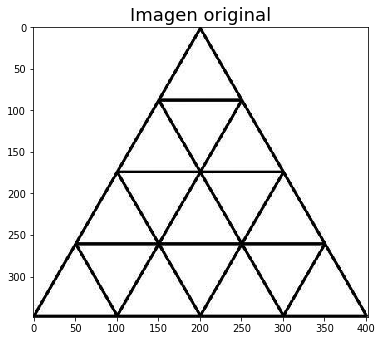

In [3]:
fig = plt.figure(figsize = (6, 6))
fig.add_subplot(1, 1, 1)
plt.imshow(triangulos, cmap = 'gray');
plt.title("Imagen original", size = 18);

In [4]:
bin_triang = np.where(triangulos < 170, 255, 0)

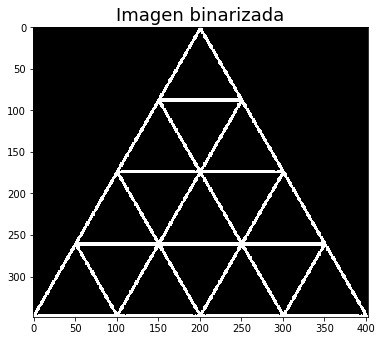

In [5]:
fig = plt.figure(figsize = (6, 6))
fig.add_subplot(1, 1, 1)
plt.imshow(bin_triang, cmap = 'gray');
plt.title("Imagen binarizada", size = 18);

In [6]:
padd_bin_triang = cv.copyMakeBorder(bin_triang, 10, 10, 10, 10, cv.BORDER_CONSTANT)
imgu8 = np.uint8(padd_bin_triang)
kernel3 = np.ones((3, 3), np.uint8)
contor = cv.erode(imgu8, kernel3, iterations = 1)

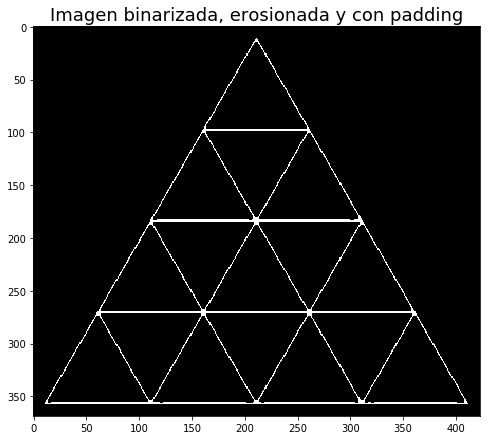

In [7]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1, 1, 1)
plt.imshow(contor, cmap = 'gray');
plt.title("Imagen binarizada, erosionada y con padding", size = 18);

__2.__ Encontrar los modelos de las rectas que forman cada arista. Para esto, solicite un umbral que elimine a las posibles aristas de longitud menor a dicho umbral. Los parámetros que debe encontrar de cada arista son $\theta$, $\rho$ y longitud. Hacer una tabla donde cada renglón sea una arista (identifíquelas con un número) y las columnas sean los parámetros indicados.

In [8]:
img_con_lineasp = cv.cvtColor(contor, cv.COLOR_GRAY2BGR)
lineas_p = cv.HoughLinesP(contor, 1, np.pi / 180, 45, None, 50, 7)
font = cv.FONT_HERSHEY_SIMPLEX 
fontScale = 0.5
color = (255, 0, 0) 
thickness = 1

for i in range(len(lineas_p)):
    l = lineas_p[i][0]
    cv.line(img_con_lineasp, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv.LINE_AA)
    org = ((l[0] + l[2]) // 2, (l[1] + l[3]) // 2)
    img_con_lineasp = cv.putText(img_con_lineasp, str(i), org, font, fontScale, color, thickness, cv.LINE_AA)

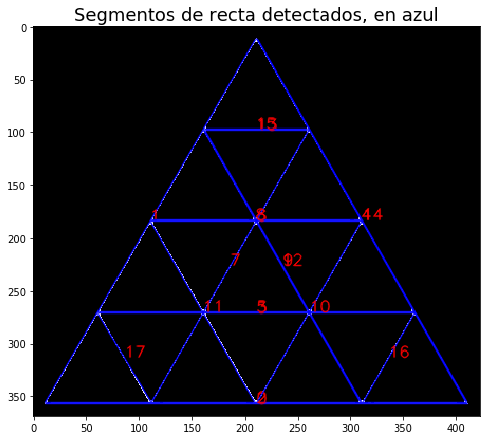

In [9]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1, 1, 1)
plt.imshow(img_con_lineasp);
plt.title("Segmentos de recta detectados, en azul", size = 18);

In [10]:
print("Se detectaron", lineas_p.shape[0], "segmentos de recta")

Se detectaron 18 segmentos de recta


Dibujando recta por recta, encuentro que 0, 5, 8, 9, 13 y 14 son redundantes. Corrijo a mano.

In [11]:
lineas_p = np.delete(lineas_p, 14, 0);
lineas_p = np.delete(lineas_p, 13, 0);
lineas_p = np.delete(lineas_p, 9, 0);
lineas_p = np.delete(lineas_p, 8, 0);
lineas_p = np.delete(lineas_p, 5, 0);
lineas_p = np.delete(lineas_p, 0, 0);

In [12]:
def obtener_houghparams(puntos):
    x1 = puntos[0]
    y1 = puntos[1]
    x2 = puntos[2]
    y2 = puntos[3]
    
    theta = math.atan((x1 - x2) / (y2 - y1))
    rho = x1 * math.cos(theta) + y1 * math.sin(theta)
    longitud = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return [round(theta * 180.0 / math.pi), round(rho), round(longitud)]

In [13]:
img_con_lineasp = cv.cvtColor(contor, cv.COLOR_GRAY2BGR)
hough_params = []

for i in range(len(lineas_p)):
    l = lineas_p[i][0]
    cv.line(img_con_lineasp, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv.LINE_AA)
    params = obtener_houghparams(l)
    hough_params.append(params)
    org = ((l[0] + l[2]) // 2, (l[1] + l[3]) // 2)
    img_con_lineasp = cv.putText(img_con_lineasp, str(i), org, font, fontScale, color, thickness, cv.LINE_AA)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in int_scalars
  import sys


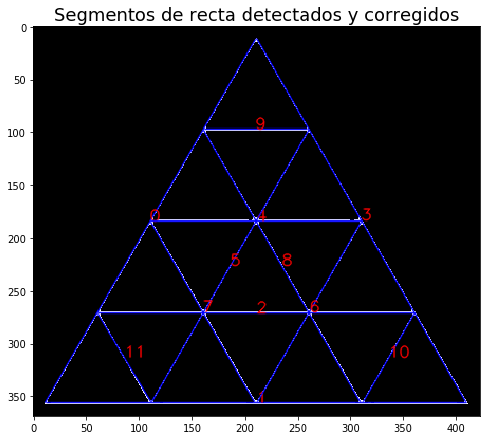

In [24]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1, 1, 1)
plt.imshow(img_con_lineasp);
plt.title("Segmentos de recta detectados y corregidos", size = 18);

In [15]:
print("segmento   theta    rho      longitud")

for i in range(len(hough_params)):
    set_ = hough_params[i]
    print(i, "\t  ", set_[0], "\t   ", set_[1], "\t", set_[2])

segmento   theta    rho      longitud
0 	   30 	    188.0 	 397
1 	   -90 	    -356.0 	 398
2 	   -90 	    -271.0 	 300
3 	   -30 	    177.0 	 397
4 	   -90 	    -184.0 	 200
5 	   30 	    275.0 	 298
6 	   30 	    361.0 	 196
7 	   -30 	    4.0 	 196
8 	   -30 	    91.0 	 297
9 	   -90 	    -97.0 	 97
10 	   30 	    448.0 	 96
11 	   -31 	    -88.0 	 97


__3.__ Encontrar las aristas que son paralelas. Reporte cuántos grupos de aristas paralelas encontró y cuáles son paralelas entre ellas.

La rectas paralelas son las que tienen mismo ángulo y distinto radio.

In [16]:
mp = dict()

for i in range(len(hough_params)):
    if hough_params[i][0] in mp.keys():
        mp[hough_params[i][0]][0].append(i)
        mp[hough_params[i][0]][1] += 1
    else: 
        mp[hough_params[i][0]] = [[i], 1]

ans = 0

for it in mp: 
    count = mp[it][1] 
    ans += (count * (count - 1)) // 2
    
print("Hay", ans, "pares de líneas paralelas.")

for trash, notrash in mp.items():
    if len(notrash[0]) > 1:
        print('Las líneas', notrash[0], 'son paralelas entre sí.')

Hay 15 pares de líneas paralelas.
Las líneas [0, 5, 6, 10] son paralelas entre sí.
Las líneas [1, 2, 4, 9] son paralelas entre sí.
Las líneas [3, 7, 8] son paralelas entre sí.


Puede parecer que la recta 11 debería aparecer junto con 3, 7 y 8, añadiendo tres pares más de líneas paralelas, pero la diferencia en el ángulo es de un grado.

__4.__ De la lista de aristas obtenidas en el objetivo 2, agrupe aquellas que formen los triángulos observados en la imagen. Haga una tabla donde los renglones identifiquen al triángulo y las columnas (3) sean los números que identifiquen a las aristas que lo forman.

Voy a considerar solo los triangulitos del centro, modificando la imagen. Para ello, voy a volver cero todos los pixeles que estén por fuera de las rectas 0, 1 y 3.

In [17]:
padd_original = cv.copyMakeBorder(triangulos, 10, 10, 10, 10, cv.BORDER_CONSTANT)
padd_original = np.where(padd_original > 170, 255, 0)
u8_original = np.uint8(padd_original)

In [18]:
r0 = lineas_p[0][0]
r3 = lineas_p[3][0]

for i in range(u8_original.shape[0]):
    for j in range(u8_original.shape[1]):
        ec0 = ((r0[3] - r0[1]) / (r0[2] - r0[0])) * (j - r0[0]) + r0[1]
        ec3 = ((r3[3] - r3[1]) / (r3[2] - r3[0])) * (j - r3[0]) + r3[1]
        if i < ec0 or i < ec3:
            u8_original[i][j] = 0

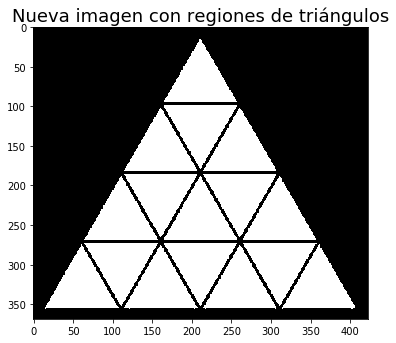

In [26]:
fig = plt.figure(figsize = (6, 6))
fig.add_subplot(1, 1, 1)
plt.imshow(u8_original, cmap = 'gray');
plt.title("Nueva imagen con regiones de triángulos", size = 18);

In [20]:
# Etiquetar triángulos
etiquetas = label(u8_original)
etiquetas_padibujo = label2rgb(etiquetas, image = u8_original)
letrero = 1

for region in regionprops(etiquetas):
    y0, x0 = region.centroid
    y0 = int(y0)
    x0 = int(x0)
    org = (x0, y0)
    etiquetas_padibujo = cv.putText(etiquetas_padibujo, str(letrero), org, font, 1, color, 2, cv.LINE_AA)
    letrero += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


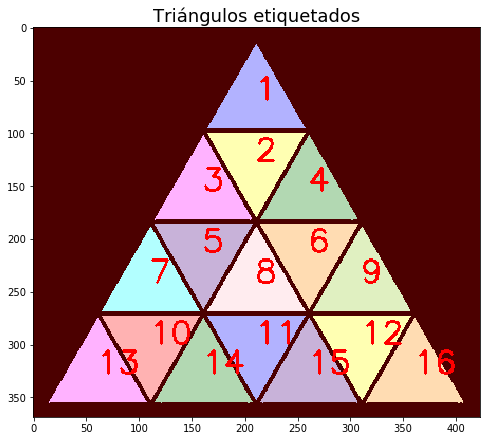

In [29]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1, 1, 1)
plt.imshow(etiquetas_padibujo);
plt.title("Triángulos etiquetados", size = 18);

In [30]:
rectas_triang = []

for i in range(letrero - 1):
    rectas_triang.append([])

for i in range(len(lineas_p)):
    l = lineas_p[i][0]
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    su_etiqueta1 = etiquetas[y1][x1]
    su_etiqueta2 = etiquetas[y2][x2]
    
    # Estos ifs revisan si algún punto de la recta está dentro de algún
    # triángulo. Si no, prueban a moverse un poquito a la izquierda
    # o a la derecha de la línea
    if su_etiqueta1 != 0:
        rectas_triang[su_etiqueta1 - 1].append(i)
    elif su_etiqueta2 != 0:
        rectas_triang[su_etiqueta2 - 1].append(i)
    else:
        xc = (x1 + x2) // 2
        yc = (y1 + y2) // 2
        xmas = xc + 10
        xmenos = xc - 10
        ymas = yc + 10
        ymenos = yc - 10
        su_etiqueta1 = etiquetas[ymas][xmenos]
        su_etiqueta2 = etiquetas[ymenos][xmas]
        
        if su_etiqueta1 != 0:
            rectas_triang[su_etiqueta1 - 1].append(i)
        elif su_etiqueta2 != 0:
            rectas_triang[su_etiqueta2 - 1].append(i)

In [31]:
print(rectas_triang)

[[], [9], [0], [], [4, 5], [3], [], [8], [], [7], [2, 6], [10], [11], [], [1], []]


In [23]:
print("triángulo   recta1   recta2   recta3")

for i in range(len(rectas_triang)):
    r1 = rectas_triang[i][0]
    r2 = rectas_triang[i][1]
    r3 = rectas_triang[i][2]
    print(i + 1, "\t   ", r1, "\t    ", r2, "      ", r3)

triángulo   recta1   recta2   recta3


IndexError: list index out of range

Pongo las dos imágenes juntas para comparar.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


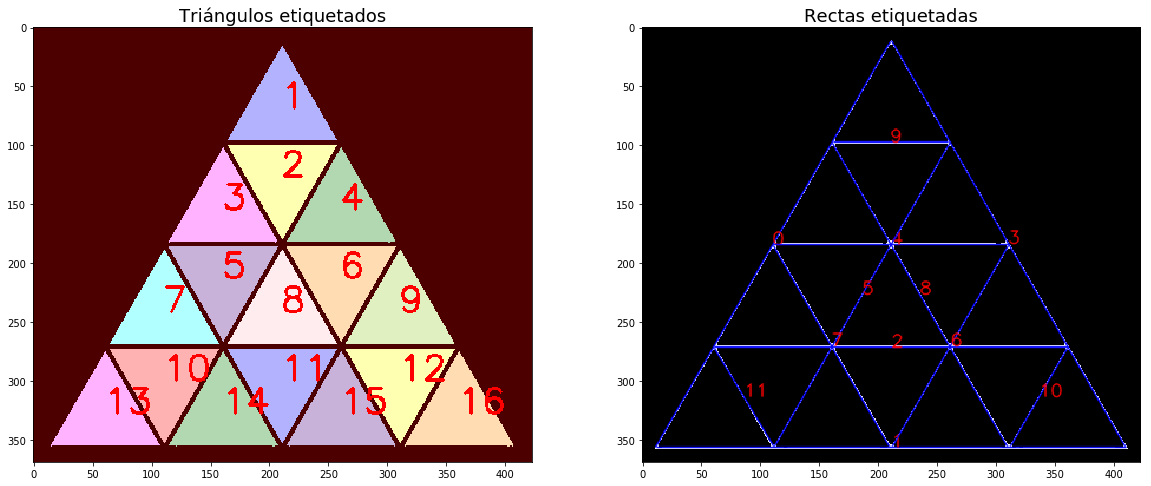

In [33]:
fig = plt.figure(figsize = (20, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(etiquetas_padibujo);
plt.title("Triángulos etiquetados", size = 18);
fig.add_subplot(1, 2, 2)
plt.imshow(img_con_lineasp);
plt.title("Rectas etiquetadas", size = 18);